In [1]:
%cd '/Users/juliencatanese/Dropbox/Datascientest/Projet_datascientest/Data_Kaggle/'
%pwd

/Users/juliencatanese/Dropbox/Datascientest/Projet_datascientest/Data_Kaggle


'/Users/juliencatanese/Dropbox/Datascientest/Projet_datascientest/Data_Kaggle'

# Data import

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# import tensorflow as tf

# Lecture des donnees PTB.csv
ptb_abnormal = pd.read_csv('./ptbdb_abnormal.csv', header=None)
ptb_normal = pd.read_csv('./ptbdb_normal.csv', header=None)

# Concatenation des deux DataFrames
ptb = pd.concat([ptb_normal, ptb_abnormal], ignore_index=True, sort=False)
ptb.rename(columns={187 :'class'}, inplace=True)

# Lecture des donnees MIT.csv
mit_train = pd.read_csv('./mitbih_train.csv', header=None)
mit_test = pd.read_csv('./mitbih_test.csv', header=None)

# Concatenation des deux DataFrames
mit = pd.concat([mit_train, mit_test], ignore_index=True, sort=False)
mit.rename(columns={187 :'class'}, inplace=True)

# Groupement des classes non-normal (1,2,3,4) en une seule classe Anormal (label=1)
mit['class'].replace({2:1,3:1,4:1}, inplace=True)

# Concatenation des jeux de donnees PTB et MIT  
data = pd.concat([ptb, mit], ignore_index=True, sort=False)

y = data['class'].copy()
X = data.drop('class', axis=1).copy()

X_train90, X_valid, y_train90, y_valid = train_test_split(X, y, train_size=0.9, random_state=1,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train90, y_train90, train_size=0.8, random_state=1,shuffle=True)
print('X_train.shape=',X_train.shape)
print('X_test.shape=',X_test.shape)
print('X_valid.shape=',X_valid.shape)


X_train.shape= (89278, 187)
X_test.shape= (22320, 187)
X_valid.shape= (12400, 187)


# initial training Model : DecisionTree(depth=3)

In [3]:
from sklearn.tree import DecisionTreeClassifier 
X = X_train
y = y_train
model = DecisionTreeClassifier(max_depth=3)
model.fit(X, y)
print('train score =',model.score(X, y))
print('test score =',model.score(X_test, y_test))

from sklearn.metrics import classification_report
y_pred = model.predict(X)
print(classification_report(y, y_pred))

train score = 0.8627321400569009
test score = 0.8618279569892473
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92     68175
         1.0       0.85      0.51      0.64     21103

    accuracy                           0.86     89278
   macro avg       0.86      0.74      0.78     89278
weighted avg       0.86      0.86      0.85     89278



In [4]:
model.score(X_test, y_test)

0.8618279569892473

In [5]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     16935
         1.0       0.85      0.52      0.64      5385

    accuracy                           0.86     22320
   macro avg       0.86      0.74      0.78     22320
weighted avg       0.86      0.86      0.85     22320



# Interpretabilility

(30.0, 40.0)

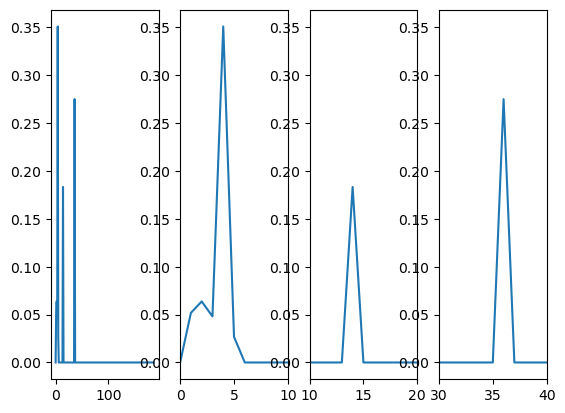

In [6]:
import matplotlib.pyplot as plt; 
%matplotlib inline
plt.subplot(141)
plt.plot(model.feature_importances_)
plt.subplot(142)
plt.plot(model.feature_importances_)
plt.xlim([0,10])
plt.subplot(143)
plt.plot(model.feature_importances_)
plt.xlim([10,20])
plt.subplot(144)
plt.plot(model.feature_importances_)
plt.xlim([30,40])

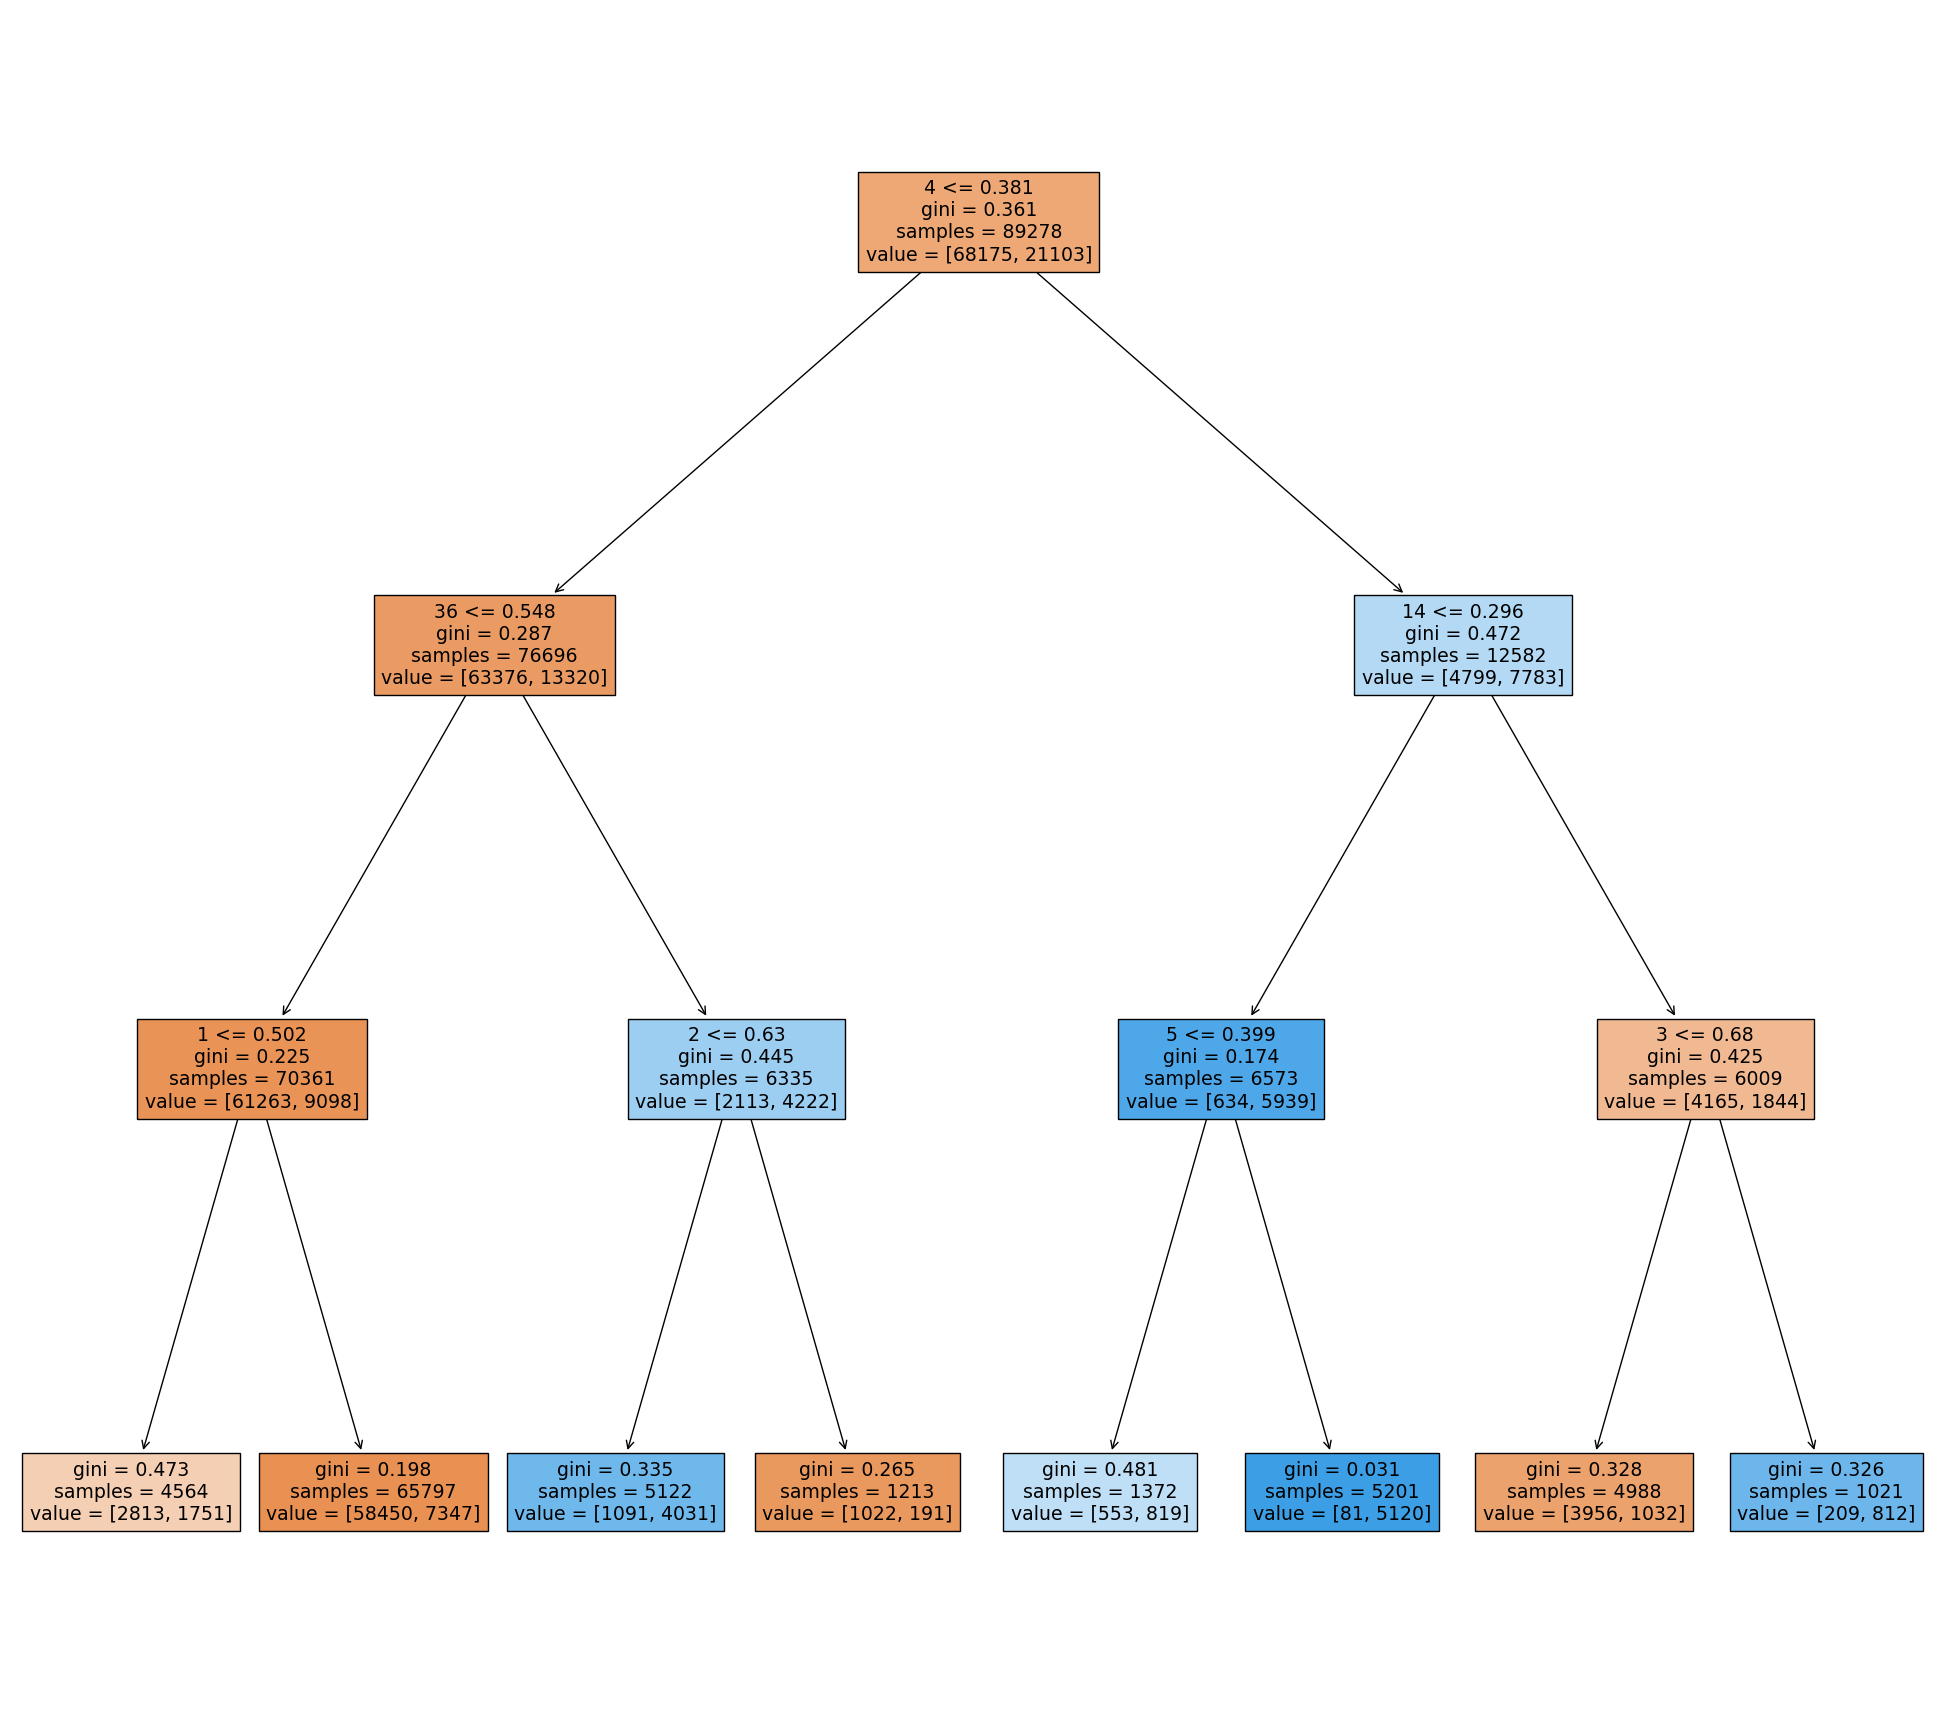

In [7]:
from sklearn.tree import plot_tree
plt.figure(figsize=(25,22))
plot_tree(model, filled=True, feature_names=X_train.columns.to_list() );

# Optimisation

In [8]:
#  DecisionTreeClassifier(criterion='gini',
#                         splitter='best', 
#                         max_depth=None, 
#                         min_samples_split=2, 
#                         min_samples_leaf=1, 
#                         min_weight_fraction_leaf=0.0, 
#                         max_features=None, 
#                         random_state=None, 
#                         max_leaf_nodes=None, 
#                         min_impurity_decrease=0.0,
#                         class_weight=None, 
#                         ccp_alpha=0.0)

# params2test = {'max_depth': range(2,10), 
#                'criterion':['gini','entropy'], 
#                'min_samples_leaf':[1,2,5,10,50,100,200], 
#                'max_features':[None, "sqrt","log2"],
#                'min_impurity_decrease':[0.0,0.01,0.1,1,10,100]
#               }

# GScv = GridSearchCV(estimator=model, 
#              param_grid=params2test, 
#              scoring=None, 
#              n_jobs=-1, 
#              refit=True, 
#              cv=10, 
#              verbose=0, 
#              pre_dispatch='2*n_jobs', 
#              error_score=np.nan, 
#              return_train_score=False); 
    
    

## Grid Search by CrossValidation

### Optimisation de la minimum sample per leaf 

In [9]:
from sklearn.model_selection import GridSearchCV

params2test = {'max_depth': [3],
               'criterion':['gini'],
               'min_samples_leaf':[1, 100, 500, 1000, 1500, 2000, 3000, 4000, 5000]}
#                'max_features':[None, "sqrt","log2"],
#                'min_impurity_decrease':[0.0, 0.1, 1]
#               }

GScv = GridSearchCV(estimator=model, 
             param_grid=params2test, 
             scoring=None, 
             n_jobs=-1, 
             refit=True, 
             cv=5, 
             verbose=0, 
             pre_dispatch='2*n_jobs', 
             error_score=np.nan, 
             return_train_score=False); 

import time
start_time = time.time()
GScv.fit(X,y)
time_elapsed= time.time() - start_time
print("====== time_elapsed = ", time_elapsed, " seconds ======" )


print(GScv.best_params_)
print(GScv.best_score_)
print(GScv.best_estimator_)

====== time_elapsed =  48.48421502113342  seconds ======
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 100}
0.8599655572467979
DecisionTreeClassifier(max_depth=3, min_samples_leaf=100)


,param_min_samples_leaf,mean_test_score
0,1,0.86
1,100,0.86
2,500,0.86
3,1000,0.86
4,1500,0.85
5,2000,0.85
6,3000,0.84
7,4000,0.84
8,5000,0.84


Text(0.5, 1.0, "Optimisation du minimum d'echantillons par feuille")

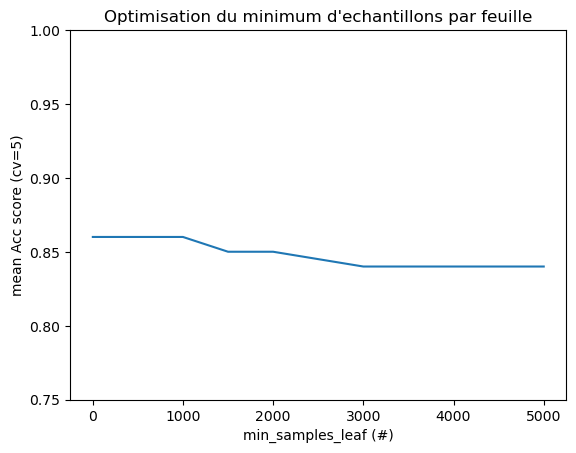

In [10]:
df_Results = pd.DataFrame(GScv.cv_results_)
df2_Results = df_Results.drop(columns= df_Results.columns[((df_Results.columns !='param_min_samples_leaf') & (df_Results.columns!='mean_test_score') )])
display(df2_Results.round(2))

plt.plot(df2_Results.param_min_samples_leaf, df2_Results.mean_test_score .round(2))
plt.ylim([0.75, 1]); 
plt.xlabel('min_samples_leaf (#)')
plt.ylabel('mean Acc score (cv=5)')
plt.title("Optimisation du minimum d'echantillons par feuille")


### optimisation de la min_impurity_decrease

In [11]:
from sklearn.model_selection import GridSearchCV

params2test = {'max_depth': [3],
               'criterion':['gini'],
               'min_samples_leaf':[1],
               'max_features':[None, "sqrt","log2"]}
#                'min_impurity_decrease':[0.0, 0.1, 1]
#               }

GScv = GridSearchCV(estimator=model, 
             param_grid=params2test, 
             scoring=None, 
             n_jobs=-1, 
             refit=True, 
             cv=5, 
             verbose=0, 
             pre_dispatch='2*n_jobs', 
             error_score=np.nan, 
             return_train_score=False); 

import time
start_time = time.time()
GScv.fit(X,y)
time_elapsed= time.time() - start_time
print("====== time_elapsed = ", time_elapsed, " seconds ======" )


print(GScv.best_params_)
print(GScv.best_score_)
print(GScv.best_estimator_)

====== time_elapsed =  11.453293085098267  seconds ======
{'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1}
0.8599319550962603
DecisionTreeClassifier(max_depth=3)


In [12]:
df_Results = pd.DataFrame(GScv.cv_results_)
df2_Results = df_Results.drop(columns= df_Results.columns[((df_Results.columns !='param_max_features') & (df_Results.columns!='mean_test_score') )])
display(df2_Results.sort_values('mean_test_score',ascending=False).round(2))


,param_max_features,mean_test_score
0,None,0.86
1,sqrt,0.83
2,log2,0.81


### Optimisation de la min_impurity_decrease

In [13]:
from sklearn.model_selection import GridSearchCV

params2test = {'max_depth': [3],
               'criterion':['gini'],
               'min_samples_leaf':[1],
               'max_features':[None],
               'min_impurity_decrease':[0.0, .0001 , .001, .01, .1, 1]
              }

GScv = GridSearchCV(estimator=model, 
             param_grid=params2test, 
             scoring=None, 
             n_jobs=-1, 
             refit=True, 
             cv=5, 
             verbose=0, 
             pre_dispatch='2*n_jobs', 
             error_score=np.nan, 
             return_train_score=False); 

import time
start_time = time.time()
GScv.fit(X,y)
time_elapsed= time.time() - start_time
print("====== time_elapsed = ", time_elapsed, " seconds ======" )


print(GScv.best_params_)
print(GScv.best_score_)
print(GScv.best_estimator_)

====== time_elapsed =  25.555262088775635  seconds ======
{'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1}
0.8599319550962603
DecisionTreeClassifier(max_depth=3)


,param_min_impurity_decrease,mean_test_score
0,0.0,0.86
1,0.0001,0.86
2,0.001,0.86
3,0.01,0.84
4,0.1,0.76
5,1,0.76


Text(0.5, 1.0, "Optimisation du minimum de diminution d'impurite par noeud")

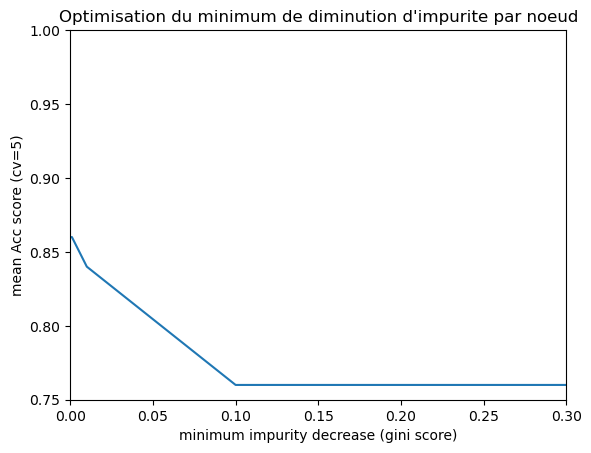

In [14]:
df_Results = pd.DataFrame(GScv.cv_results_)
idx2remove = (df_Results.columns !='param_min_impurity_decrease') & (df_Results.columns!='mean_test_score')
df2_Results = df_Results.drop(columns= df_Results.columns[idx2remove])
display(df2_Results.sort_values('mean_test_score',ascending=False).round(2))


plt.plot(df2_Results.param_min_impurity_decrease, df2_Results.mean_test_score .round(2))
plt.ylim([0.75, 1]); plt.xlim([0, 0.3]); 

plt.xlabel('minimum impurity decrease (gini score)')
plt.ylabel('mean Acc score (cv=5)')
plt.title("Optimisation du minimum de diminution d'impurite par noeud")

### Optimisation de la profondeur

In [15]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import classification_report

X = X_train
y = y_train


train score = 0.8466699522838773
test score = 0.8447132616487455
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91     68175
         1.0       0.79      0.48      0.60     21103

    accuracy                           0.85     89278
   macro avg       0.82      0.72      0.75     89278
weighted avg       0.84      0.85      0.83     89278



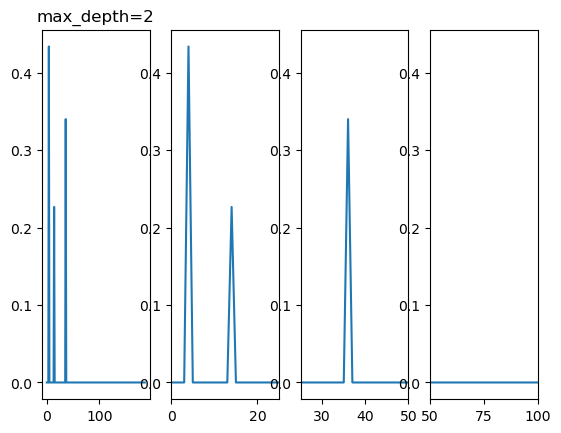

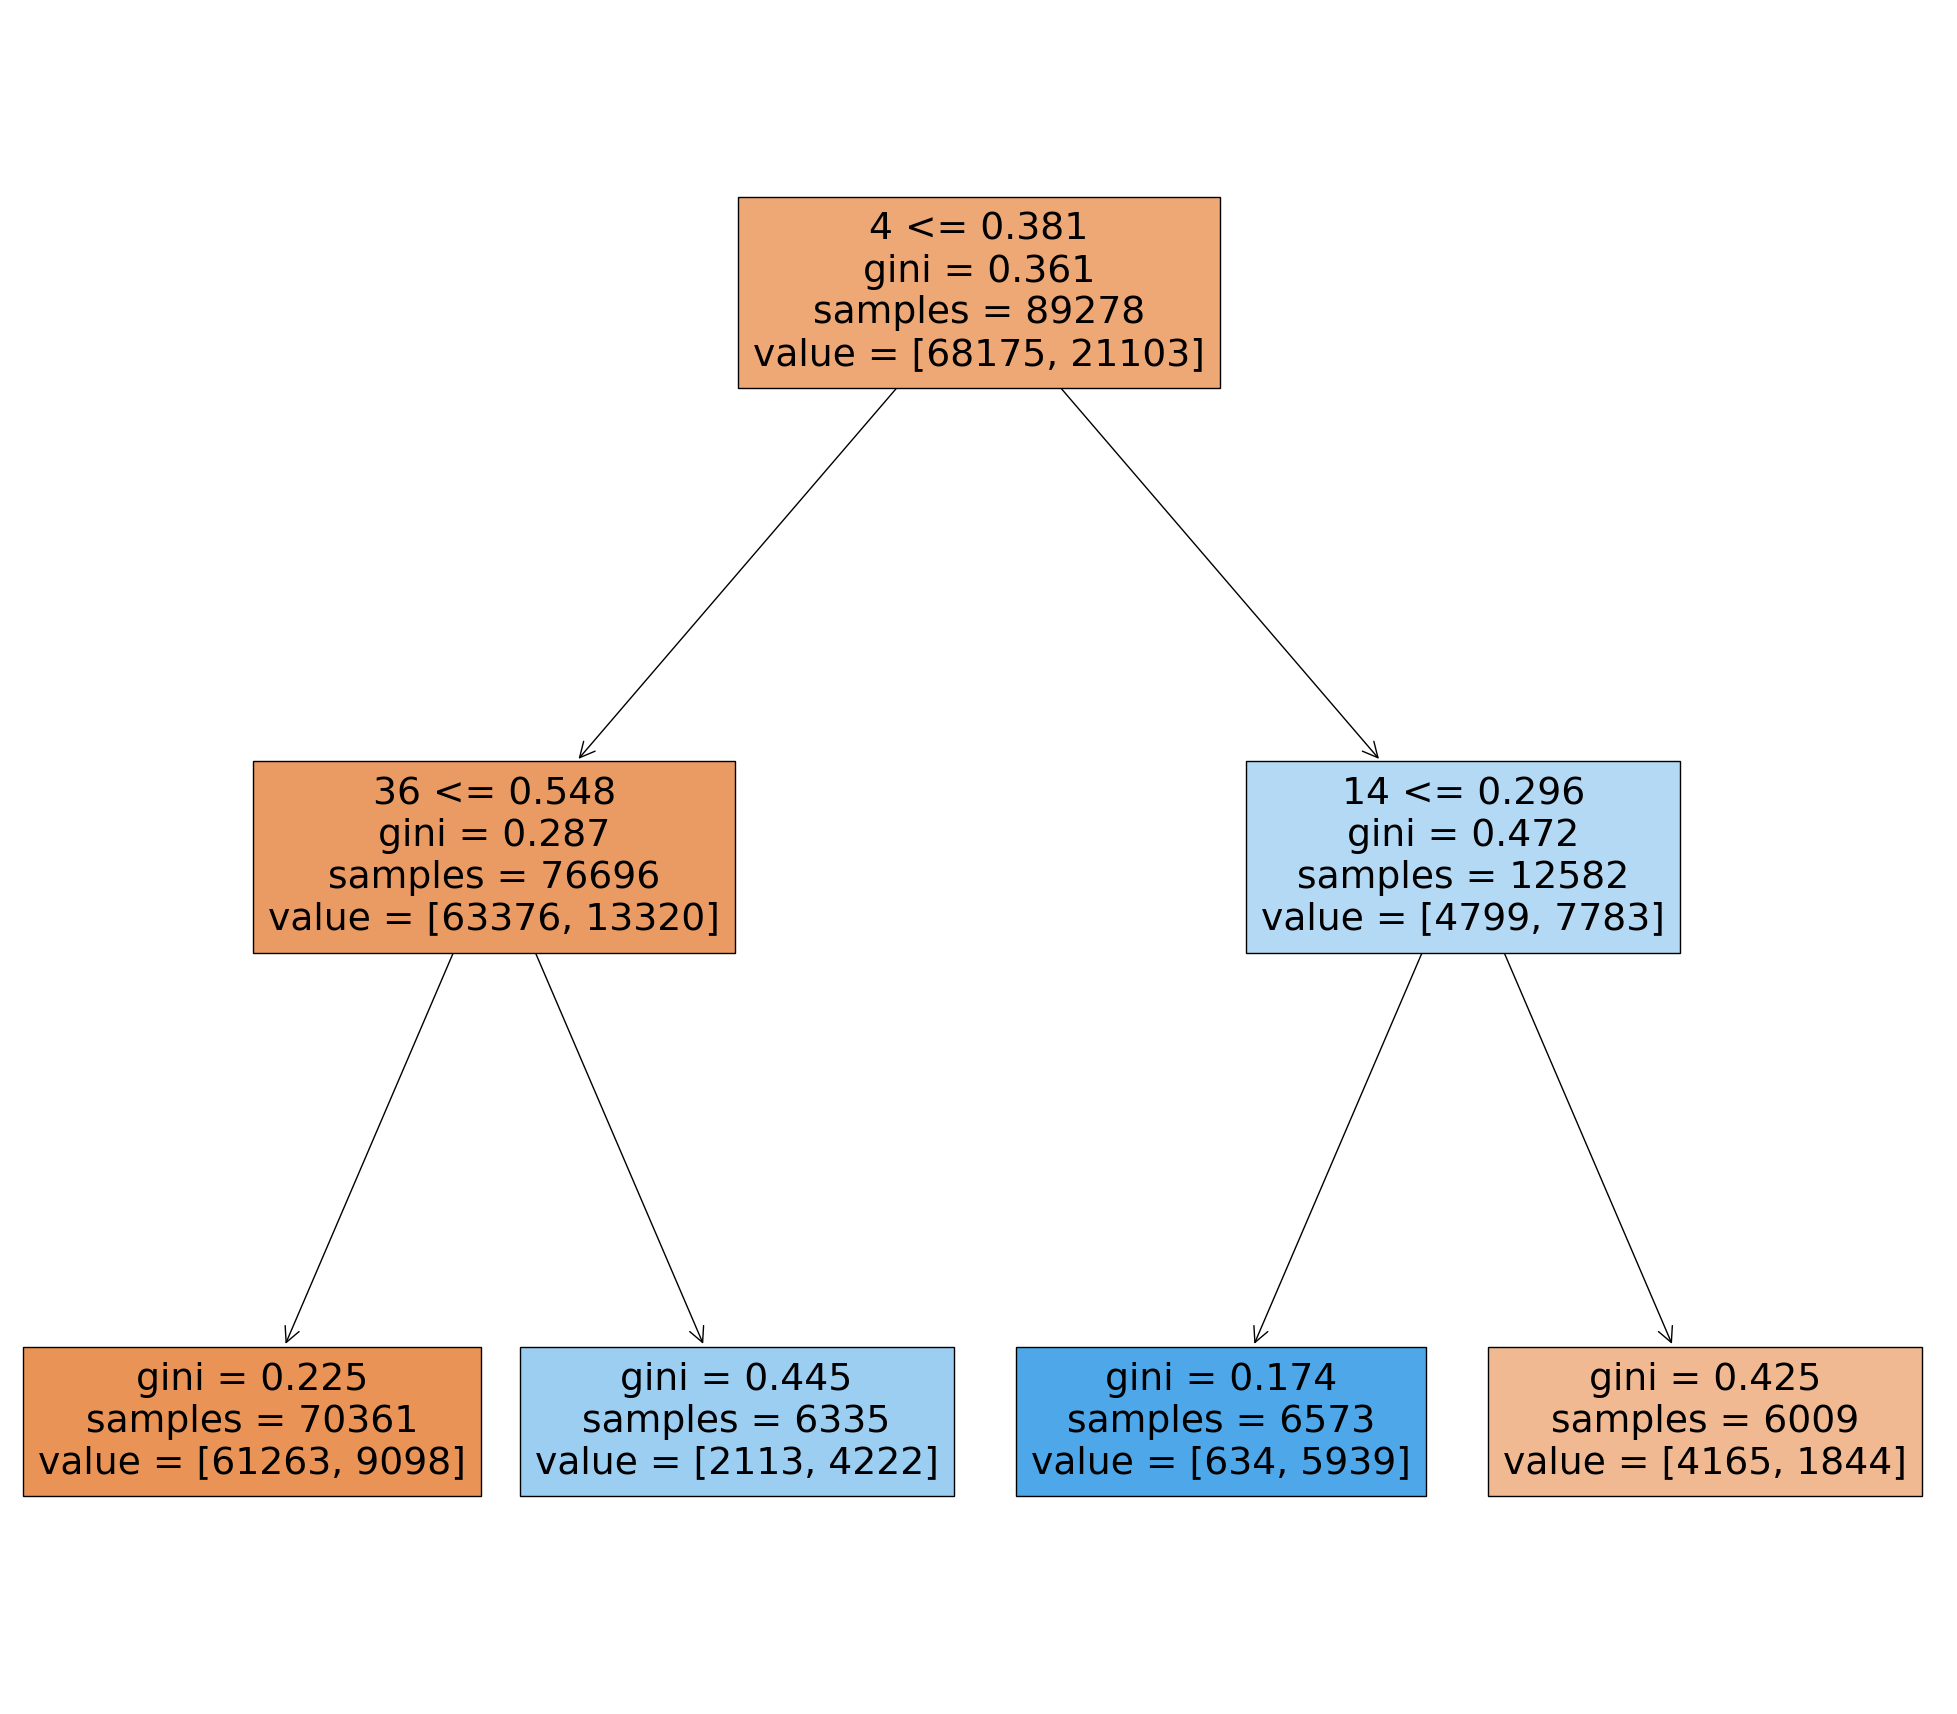

In [16]:
max_depth = 2
model = DecisionTreeClassifier(max_depth=max_depth, random_state = 123)
model.fit(X, y)
print('train score =',model.score(X, y))
print('test score =',model.score(X_test, y_test))
y_pred = model.predict(X)
print(classification_report(y, y_pred))

plt.subplot(141)
plt.plot(model.feature_importances_)
plt.title('max_depth=' + str(max_depth))
plt.subplot(142)
plt.plot(model.feature_importances_)
plt.xlim([0,25])
plt.subplot(143)
plt.plot(model.feature_importances_)
plt.xlim([25,50])
plt.subplot(144)
plt.plot(model.feature_importances_)
plt.xlim([50,100])

plt.figure(figsize=(25,22))
plot_tree(model, filled=True, feature_names=X_train.columns.to_list() );

train score = 0.8627321400569009
test score = 0.8618279569892473
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92     68175
         1.0       0.85      0.51      0.64     21103

    accuracy                           0.86     89278
   macro avg       0.86      0.74      0.78     89278
weighted avg       0.86      0.86      0.85     89278



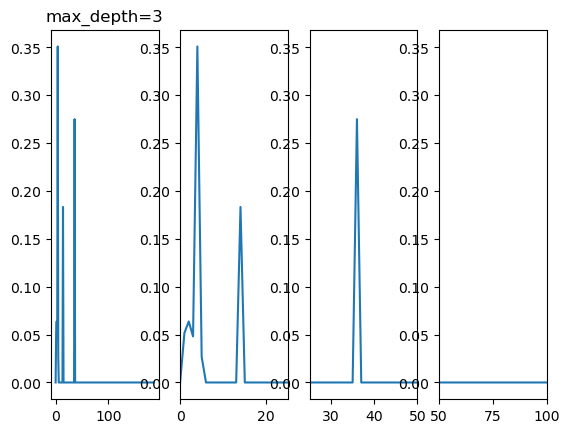

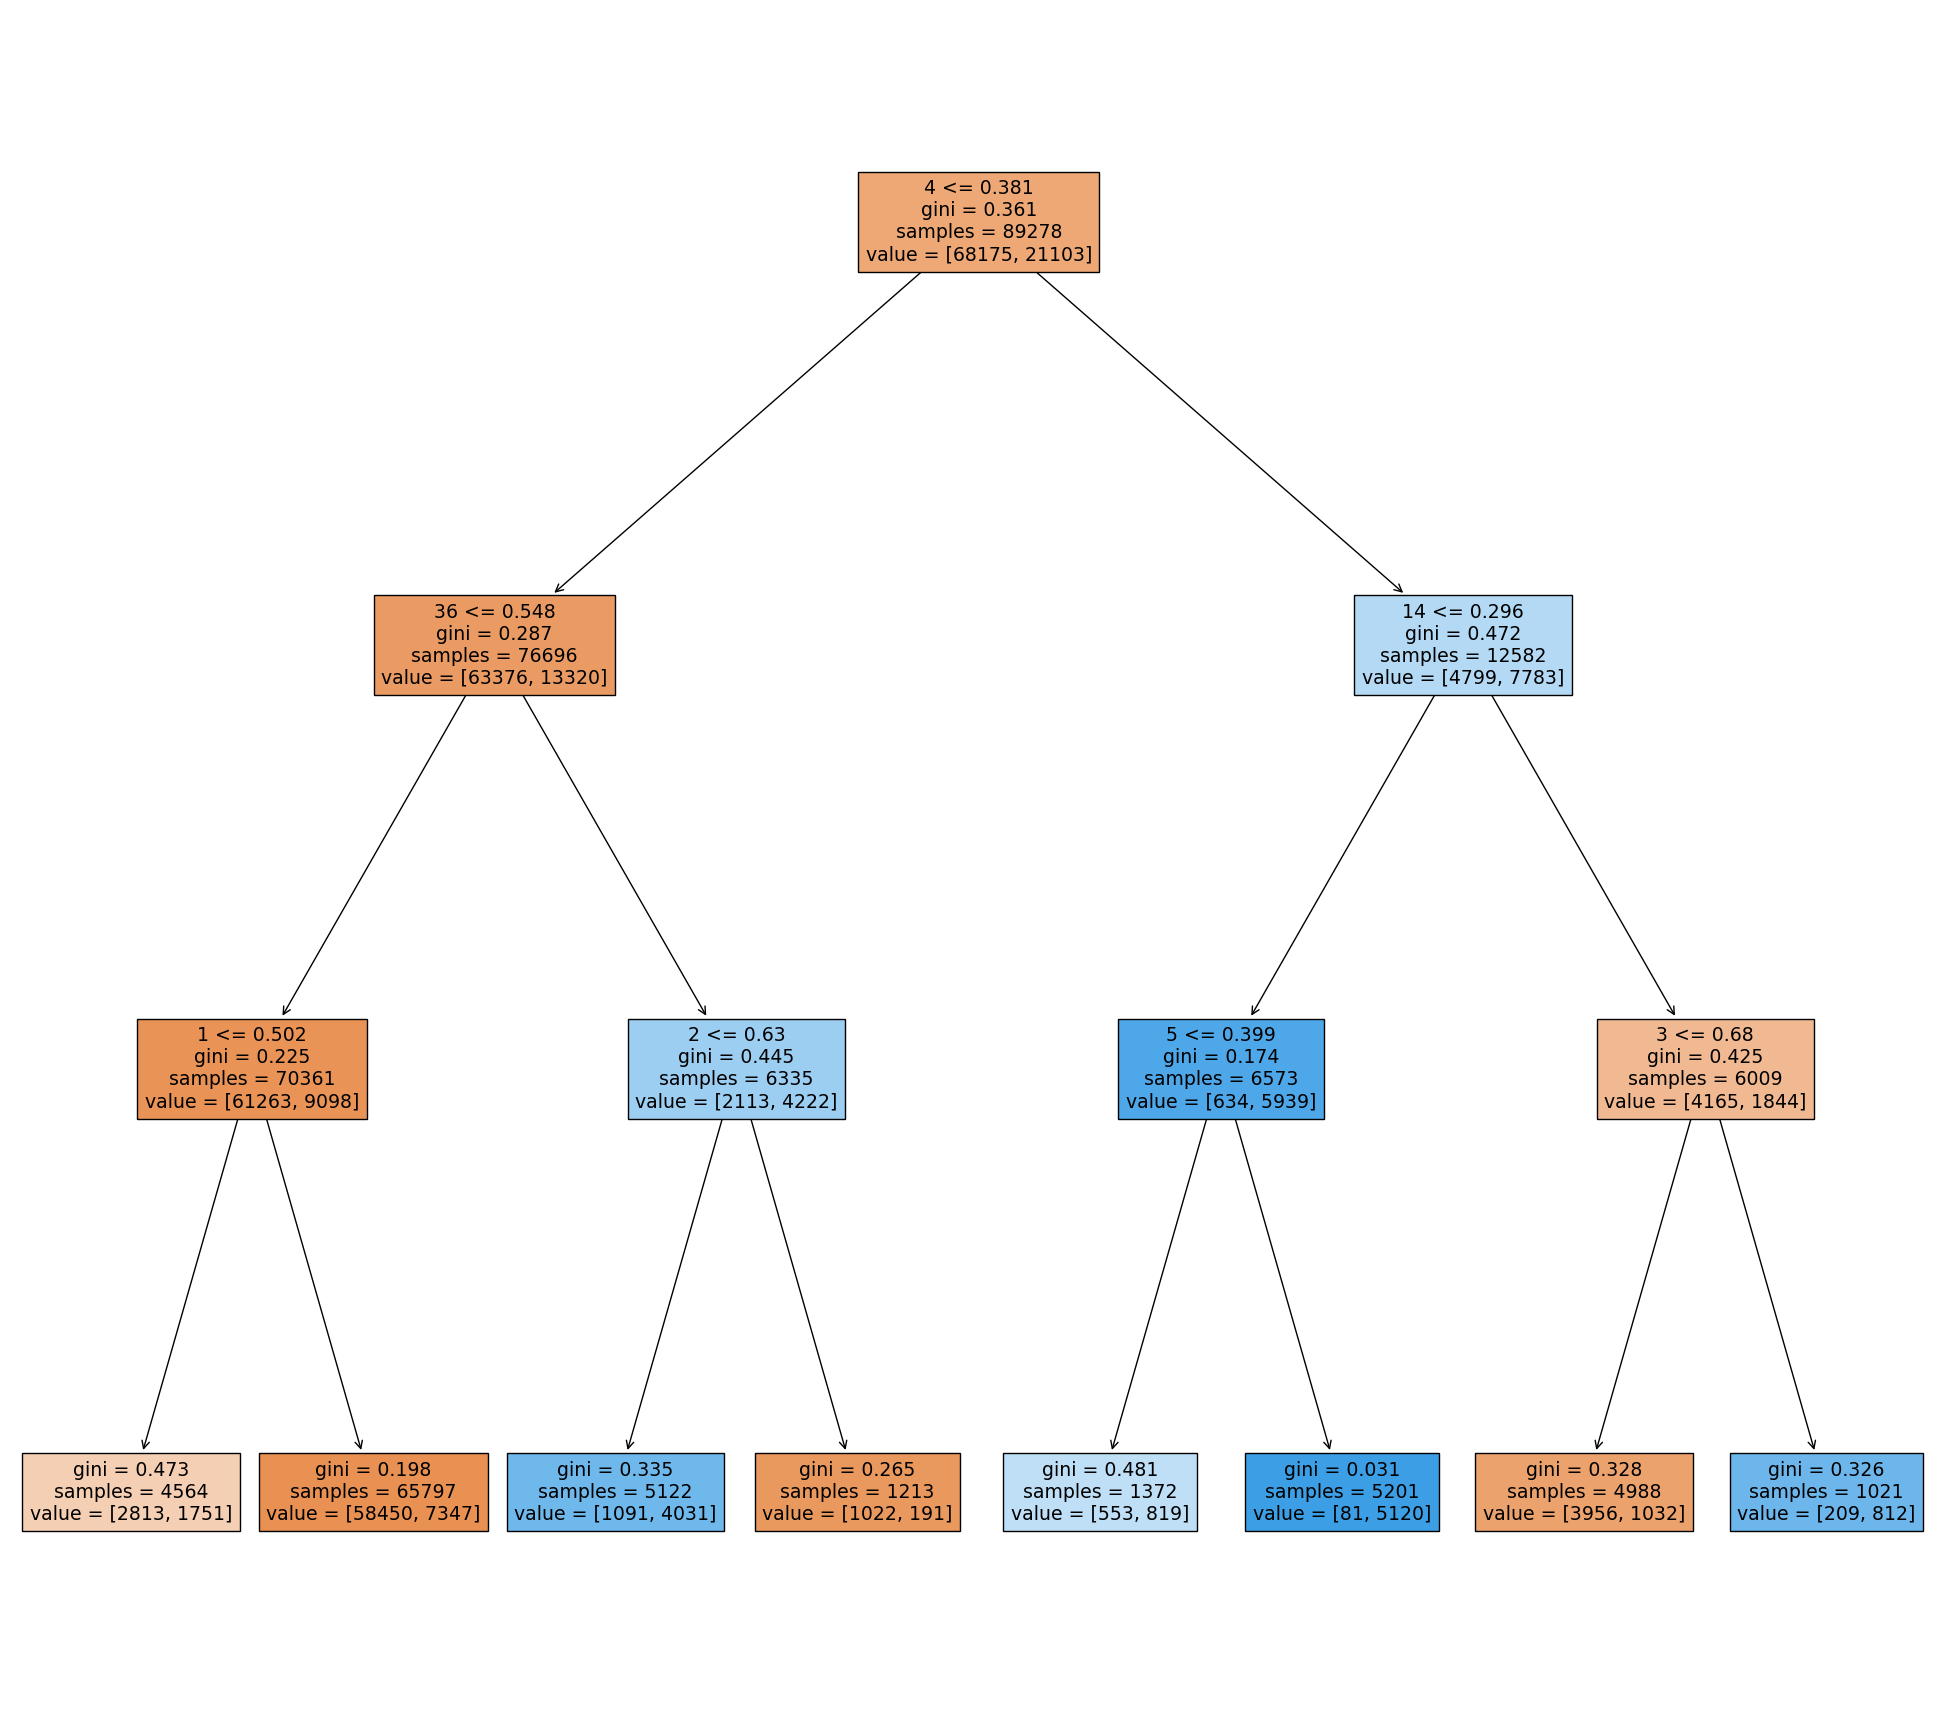

In [17]:
max_depth = 3
model = DecisionTreeClassifier(max_depth=max_depth, random_state = 123)
model.fit(X, y)
print('train score =',model.score(X, y))
print('test score =',model.score(X_test, y_test))
y_pred = model.predict(X)
print(classification_report(y, y_pred))

plt.subplot(141)
plt.plot(model.feature_importances_)
plt.title('max_depth=' + str(max_depth))
plt.subplot(142)
plt.plot(model.feature_importances_)
plt.xlim([0,25])
plt.subplot(143)
plt.plot(model.feature_importances_)
plt.xlim([25,50])
plt.subplot(144)
plt.plot(model.feature_importances_)
plt.xlim([50,100])

plt.figure(figsize=(25,22))
plot_tree(model, filled=True, feature_names=X_train.columns.to_list() );

train score = 0.8711440668473757
test score = 0.8680555555555556
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     68175
         1.0       0.85      0.55      0.67     21103

    accuracy                           0.87     89278
   macro avg       0.86      0.76      0.80     89278
weighted avg       0.87      0.87      0.86     89278



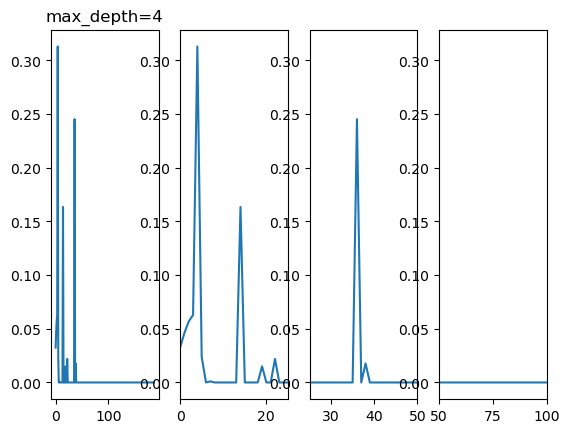

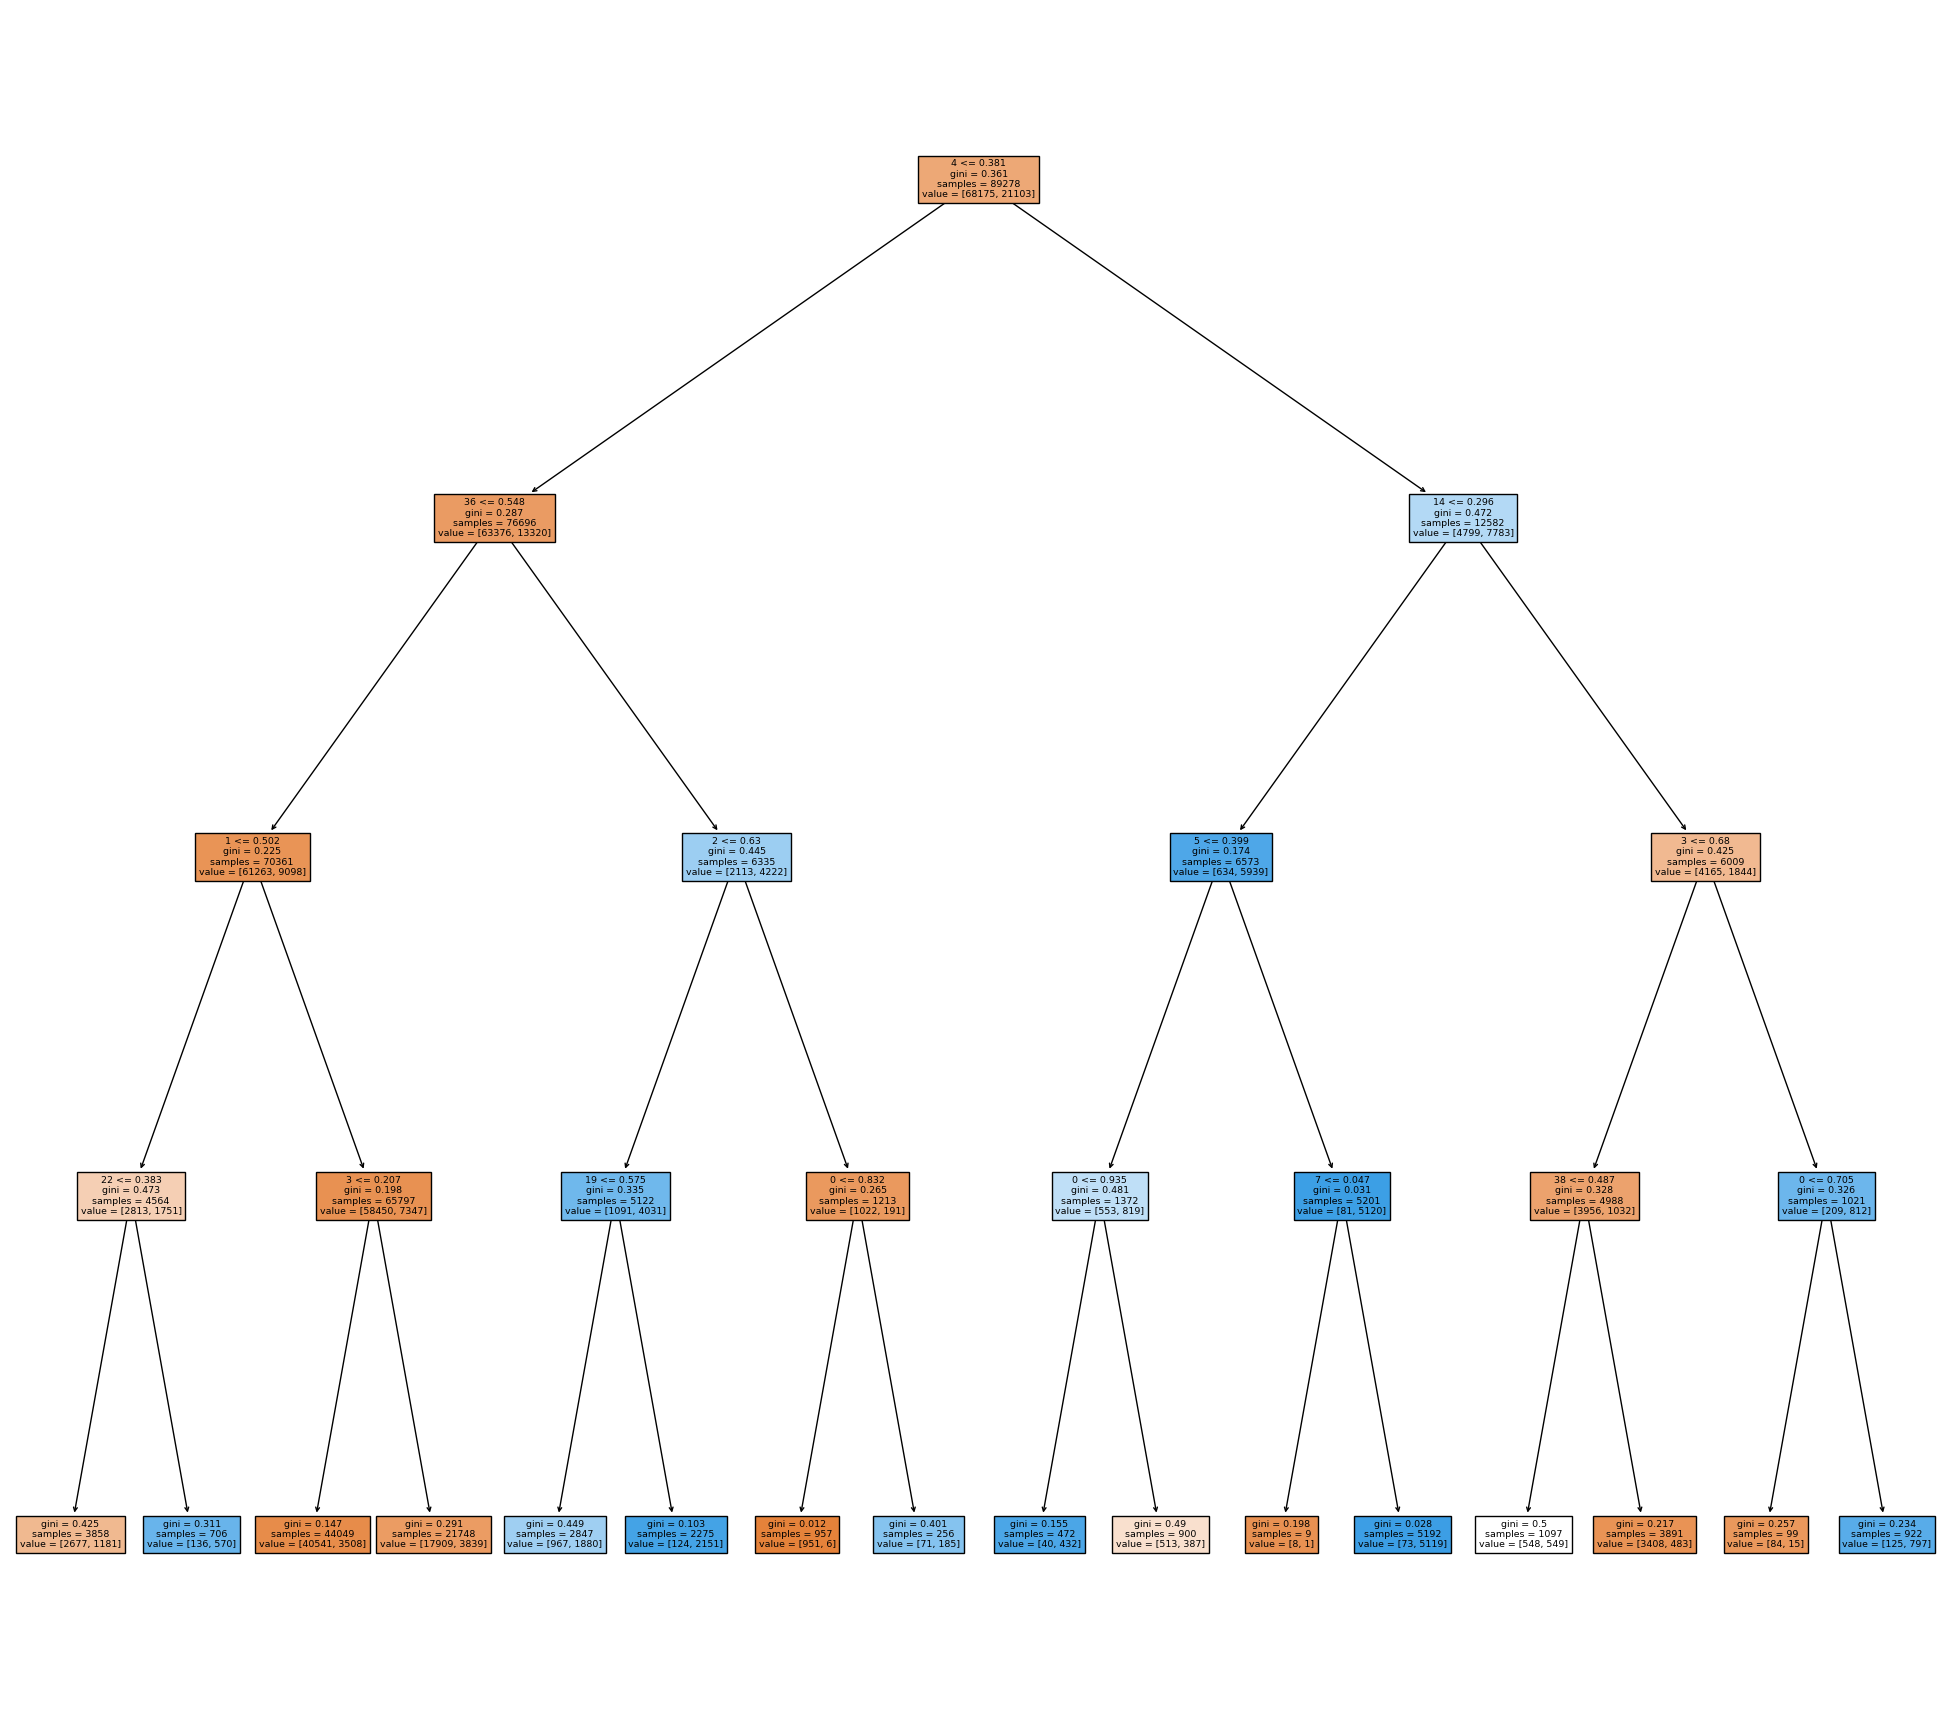

In [18]:
max_depth = 4
model = DecisionTreeClassifier(max_depth=max_depth, random_state = 123)
model.fit(X, y)
print('train score =',model.score(X, y))
print('test score =',model.score(X_test, y_test))
y_pred = model.predict(X)
print(classification_report(y, y_pred))

plt.subplot(141)
plt.plot(model.feature_importances_)
plt.title('max_depth=' + str(max_depth))
plt.subplot(142)
plt.plot(model.feature_importances_)
plt.xlim([0,25])
plt.subplot(143)
plt.plot(model.feature_importances_)
plt.xlim([25,50])
plt.subplot(144)
plt.plot(model.feature_importances_)
plt.xlim([50,100])

plt.figure(figsize=(25,22))
plot_tree(model, filled=True, feature_names=X_train.columns.to_list() );

train score = 0.8823786375142812
test score = 0.8783154121863799
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93     68175
         1.0       0.91      0.55      0.69     21103

    accuracy                           0.88     89278
   macro avg       0.90      0.77      0.81     89278
weighted avg       0.89      0.88      0.87     89278



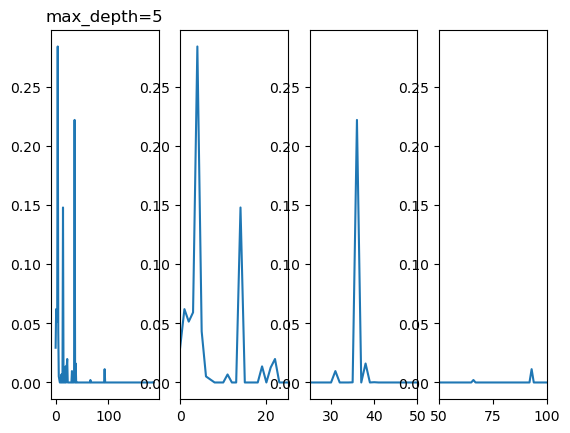

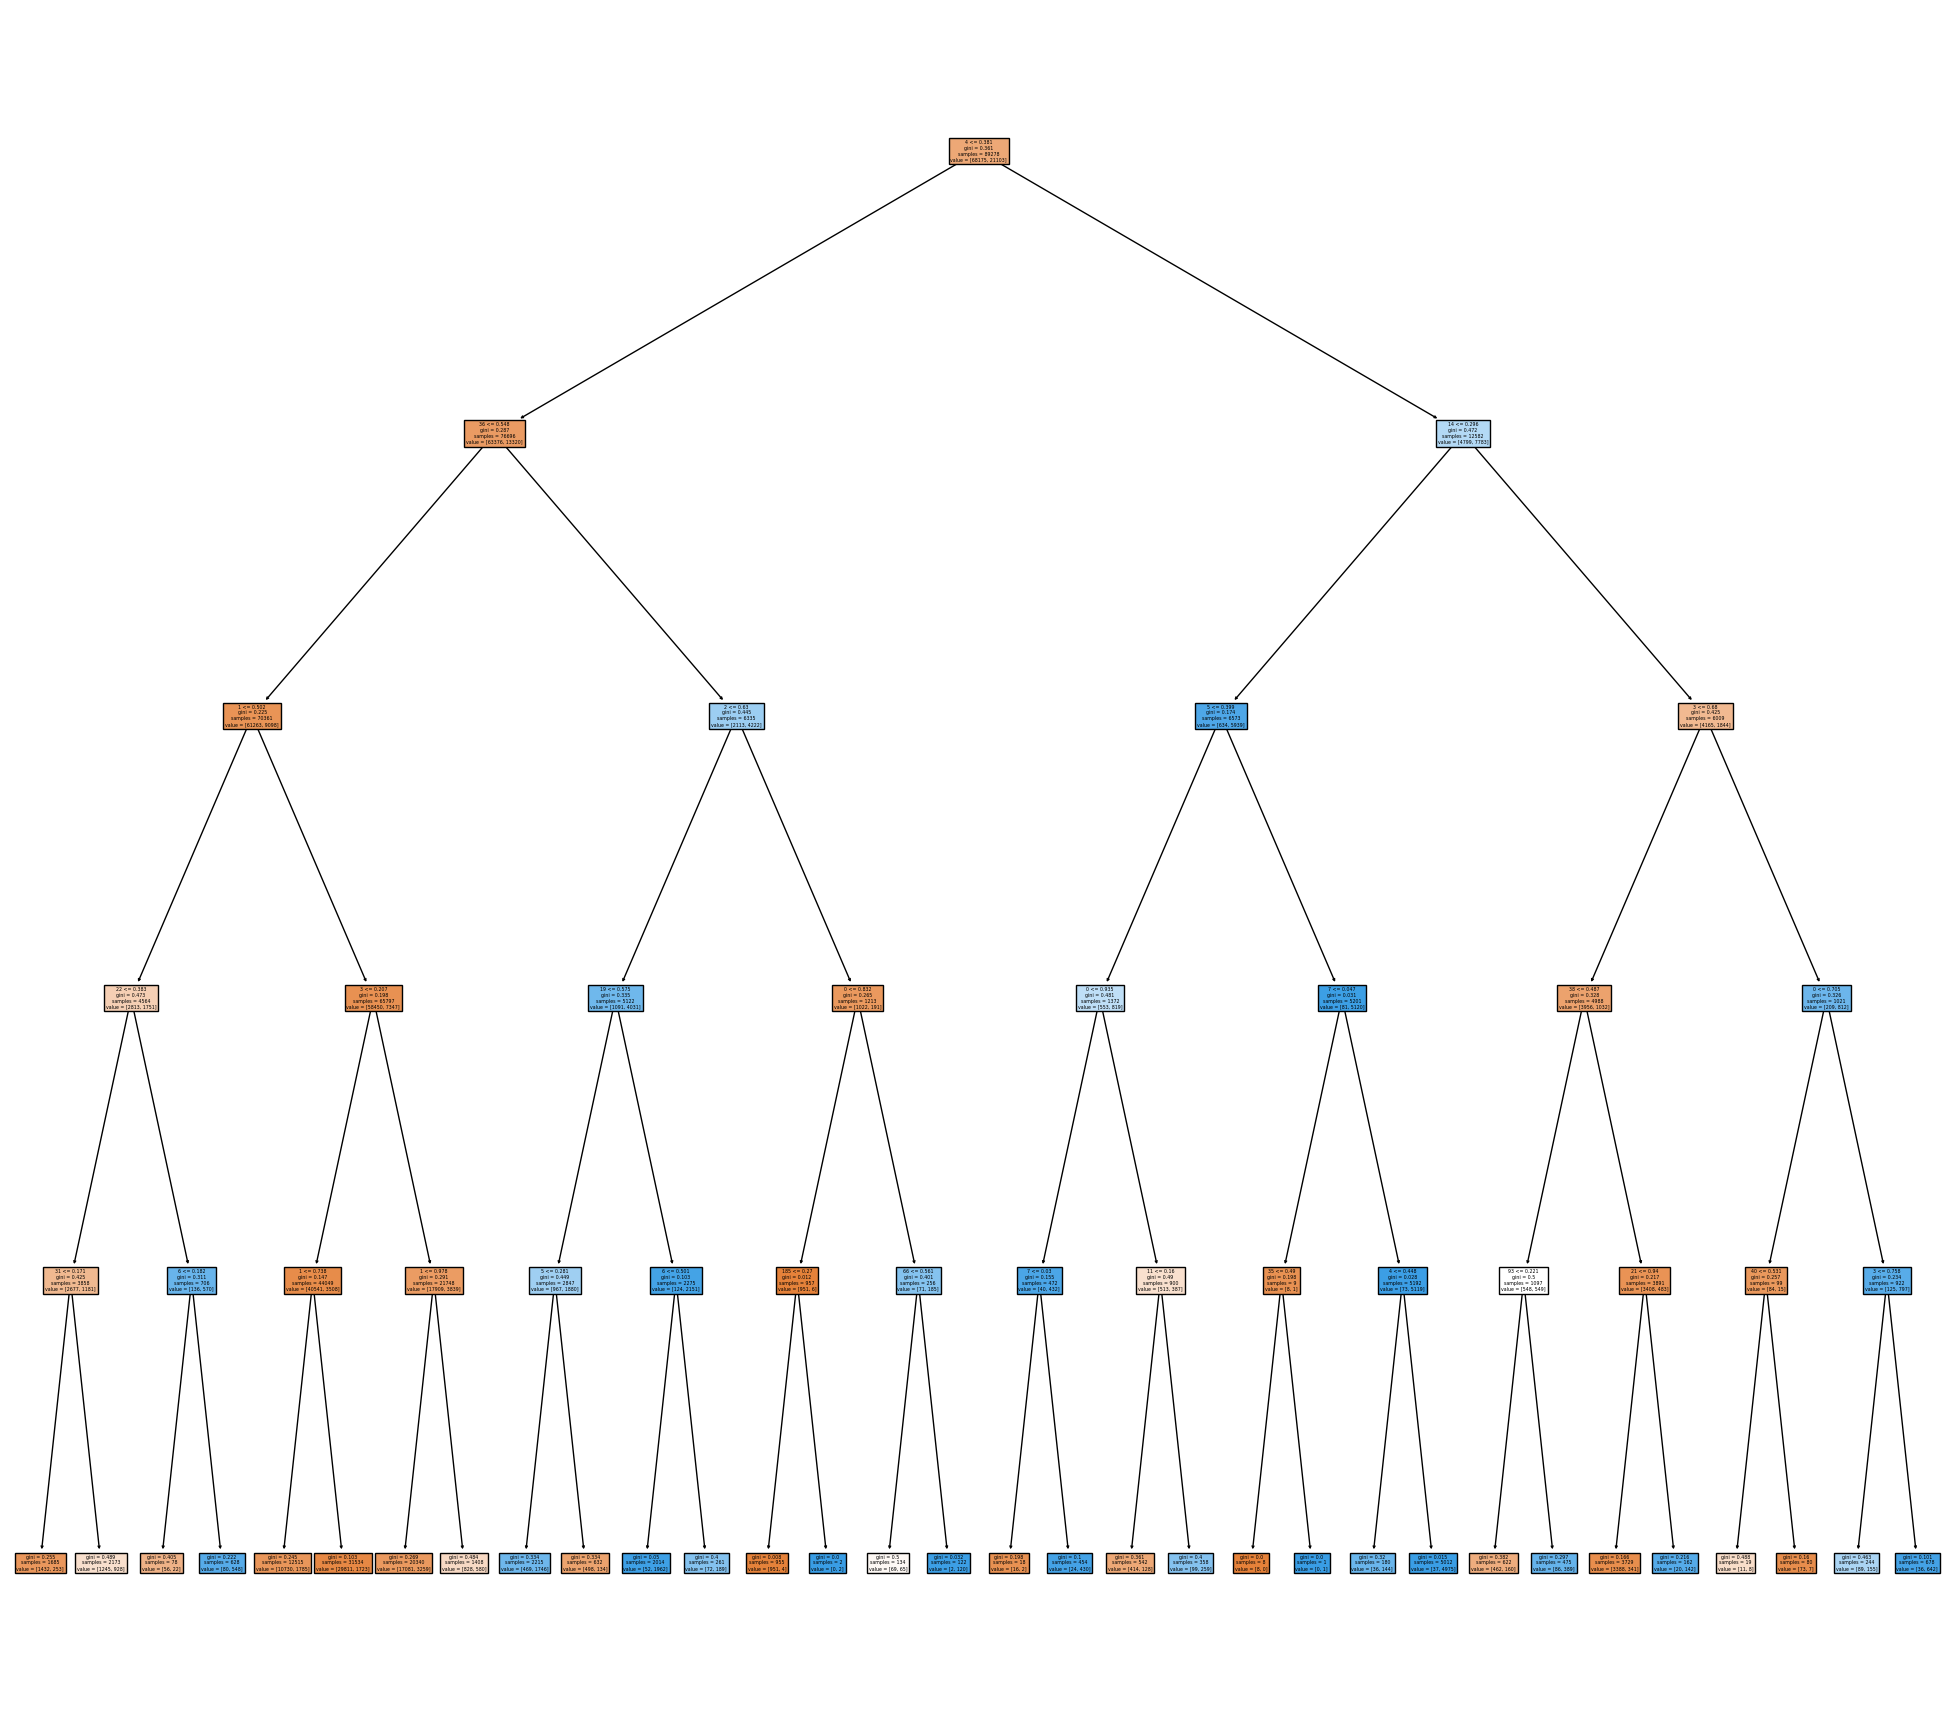

In [19]:
max_depth = 5
model = DecisionTreeClassifier(max_depth=max_depth, random_state = 123)
model.fit(X, y)
print('train score =',model.score(X, y))
print('test score =',model.score(X_test, y_test))
y_pred = model.predict(X)
print(classification_report(y, y_pred))

plt.subplot(141)
plt.plot(model.feature_importances_)
plt.title('max_depth=' + str(max_depth))
plt.subplot(142)
plt.plot(model.feature_importances_)
plt.xlim([0,25])
plt.subplot(143)
plt.plot(model.feature_importances_)
plt.xlim([25,50])
plt.subplot(144)
plt.plot(model.feature_importances_)
plt.xlim([50,100])

plt.figure(figsize=(25,22))
plot_tree(model, filled=True, feature_names=X_train.columns.to_list() );

In [ ]:
model = DecisionTreeClassifier(max_depth=20, random_state = 123)
model.fit(X, y)
print('train score =',model.score(X, y))
print('test score =',model.score(X_test, y_test))
y_pred = model.predict(X)
print(classification_report(y, y_pred))

In [ ]:
import matplotlib.pyplot as plt; 
%matplotlib inline
plt.subplot(141)
plt.plot(model.feature_importances_)
plt.subplot(142)
plt.plot(model.feature_importances_)
plt.xlim([0,25])
plt.subplot(143)
plt.plot(model.feature_importances_)
plt.xlim([25,50])
plt.subplot(144)
plt.plot(model.feature_importances_)
plt.xlim([50,100])

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(25,22))
plot_tree(model, filled=True, feature_names=X_train.columns.to_list() );

In [ ]:
test_score=[]; 
train_score=[]; 
Xaxis=[];
ImportanceCurve=[];

for max_depth in range(4,21,4): 
    print('max_depth=',max_depth)
    Xaxis.append(max_depth) 
    model = DecisionTreeClassifier(max_depth=max_depth, random_state = 123)
    model.fit(X, y)
    train_score.append(model.score(X, y))
    test_score.append(model.score(X_test, y_test))  
    ImportanceCurve.append(model.feature_importances_)

    
plt.figure(2)
plt.plot(Xaxis,test_score, label='test')
plt.plot(Xaxis,train_score, label='train')
plt.legend(); plt.ylabel('score'); plt.xlabel('depth')



In [ ]:
plt.figure(3)
for i in range(len(Xaxis)):
    plt.plot(ImportanceCurve[i], label= 'profondeur =' + str(Xaxis[i]))
plt.legend();
plt.xlabel('points du signal ECG')
plt.ylabel('Importance')
plt.title("La Profondeur a peu d'effet sur l'Importance")

plt.axes([0.45, 0.25, 0.4, 0.3])
plt.plot(np.mean(ImportanceCurve,axis=0), 'k' ,lw=0.8);
plt.plot(np.std(ImportanceCurve,axis=0) + np.mean(ImportanceCurve,axis=0), '--c', lw=0.5);
plt.plot(- np.std(ImportanceCurve,axis=0) + np.mean(ImportanceCurve,axis=0), '--c', lw=0.5);
plt.xlim([0,37]), 
plt.xticks(range(0,37,4));
plt.title('average+/-std')



In [ ]:
    
plt.figure(2)
plt.plot(Xaxis,test_score, '-d',label='test',lw=2)
plt.plot(Xaxis,train_score, '-o',label='train', lw=2)
plt.legend(); 
plt.ylabel('accuracy moyenne (cv=5)'); 
plt.xlabel('profondeur');
plt.xticks(Xaxis);
plt.ylim([0.75, 1]);
plt.title('Le score augmente avec la profondeur')
plt.annotate('Attention au sur-apprentissage', xy=[15, 0.88], xytext=[12, 0.83],arrowprops={'facecolor':'red'})
plt.plot([20,20,8,8,20],[.99,.88,.88,.99,.99],'--r', lw=0.6)

In [ ]:
test_score

# RE-EQUILIBRAGE des Donnees 


In [ ]:
import imblearn
import imblearn.under_sampling
from imblearn.under_sampling import RandomUnderSampler 
RUS = RandomOverSampler()
X_train_rus, y_train_rus = RUS.fit_resample(X_train, y_train)


In [ ]:
from sklearn.tree import DecisionTreeClassifier 
X = X_train_rus
y = y_train_rus
model = DecisionTreeClassifier(max_depth=3)
model.fit(X, y)
print('train score =',model.score(X, y))
print('test score =',model.score(X_test, y_test))

from sklearn.metrics import classification_report
y_pred = model.predict(X)
print(classification_report(y, y_pred))